<a href="https://colab.research.google.com/github/appletreeleaf/Projects/blob/main/Project2_MRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requirements

## Import Libraries

In [ ]:
!pip install transformers
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import math
import csv
import json
from statistics import mean
from typing import List, Tuple, Dict, Any
import uuid
import pandas as pd

from tqdm.notebook import tqdm
from easydict import EasyDict as edict

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AutoModel, AutoConfig

In [ ]:
for name in 'models', 'submissions':
    os.makedirs(name, exist_ok=True)

##Set Arguments, HyperParameters

In [ ]:
args = edict({'w_project': 'test_project_2_JY_02',  #goorm_project_2
              'w_entity': 'goorm_team_1',
              'learning_rate': 5e-5,
              'batch_size': {'train': 128,
                             'eval': 32,
                             'test': 128},
              'accumulate': 32,     # 32개씩 배치 처리
              'epochs': 1,
              'seed': 42,
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 1024})

args['NAME'] = ''f'Kobigbird_v2_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

Kobigbird_v2_ep1_max1024_lr5e-05_113


#Initialize

##Wandb

In [ ]:
wandb.login() # API key = bcc72b6f4c340bf778bb3310374ab78fc660206e

wandb: Currently logged in as: 02younge. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project = args.w_project, entity = args.w_entity) # (project name, project_department)

wandb: Currently logged in as: 02younge (goorm_team_1). Use `wandb login --relogin` to force relogin


##Set Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

##Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name) # KoBigBird tokenizer = bert tokenizer

##Model

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
model.cuda()

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.predictions.decoder.bias', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

BigBirdForQuestionAnswering(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32500, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0): BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

##Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

#Datasets

##Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# context 전처리
import re

def clean_str(text):
  pattern1 = '[一-龥]'    # 한자 제거
  prog1 = re.compile(pattern1)
  pattern2 = '[-=+,#/\?:^@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]' #특수 기호
  prog2 = re.compile(pattern2)
  pattern3 = '\([^\)]+\)' # (...) 패턴
  prog3 = re.compile(pattern3)

  result = prog1.sub(repl='', string=text)
  result = prog2.sub(repl='', string=result)
  result = prog3.sub(repl='', string=result)

  return result


In [ ]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))

        return cls(data, indices)

    # Json을 불러오는 메소드
    @classmethod
        def loads(cls, *file_path: str):
        datas = {'data': []}
        indices = []

        for f in file_path:
            with open(f, 'r', encoding='utf-8') as fd:
                data = json.load(fd)
            datas['data'] += data['data']

        for d_id, document in enumerate(datas['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))

        return cls(datas, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.5):
        indices = list(dataset._indices)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        if 'guid' in qa:
            guid = qa['guid']
        else:
            guid = uuid.uuid4().hex

        context = paragraph['context']

        question = qa['question']

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', ' ').replace('\xa0', ' ').replace('\u200b', ' ')
        else:
            answers = None


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [ ]:
train_path = '/content/drive/MyDrive/Groom_8th_project2/train.json'
train2_path = '/content/drive/MyDrive/Groom_8th_project2/train2.json'

dataset = KoMRC.loads(train_path, train2_path)
len(dataset) # 255462

255462

##Tokenize & Tag Token Positions

In [ ]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)

        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)

        return tokens


    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No Matched end position")

                answers.append({
                    'start': start,
                    'end': end
                  })
            answer_text = sample['answers'][0]['text']

        else:
            answers = None
            answer_text = None

        return {
            'guid': sample['guid'],
            'context_original': clean_str(sample['context']),
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers,
            'answers_text': answer_text
        }

In [ ]:
dataset = TokenizedKoMRC.loads(train_path, train2_path)
dataset_, remain = TokenizedKoMRC.split(dataset) # 5:5 절반만 남기기
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset_, eval_ratio=0.1)


print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))

Number of Train Samples: 114958
Number of Dev Samples: 12773


##input

In [ ]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context

        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)   # <CLS>+question, <SEP>+contexts+<SEP>

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [ ]:
indexer = Indexer(list(tokenizer.vocab.keys()))
print(indexer)

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)
len(indexed_train_dataset)

114958

##Collate

In [ ]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)

        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

##Data Loader

In [ ]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [ ]:
batch = next(iter(train_loader))
batch = next(iter(dev_loader))
print(batch['input_ids'])
print(batch['input_ids'].shape)
print(list(batch.keys()))

tensor([[    2,  7754,  4561,  ...,     0,     0,     0],
        [    2,  8899,  6887,  ...,     0,     0,     0],
        [    2,  6955,  9888,  ...,     0,     0,     0],
        ...,
        [    2,  7487, 12295,  ...,     0,     0,     0],
        [    2,  6851,  8298,  ...,     0,     0,     0],
        [    2,  6938,  7051,  ...,     0,     0,     0]])
torch.Size([32, 1024])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']


#Train

In [ ]:
# 자체 평가를 위한 levenstein-distance

def calc_distance(a, b):
    ''' 레벤슈타인 거리 계산하기 '''
    if a == b:
        return 0 # 같으면 0을 반환

    a_len = len(a) # a 길이
    b_len = len(b) # b 길이
    if a == "":
        return b_len
    if b == "":
        return a_len

    matrix = [[] for i in range(a_len+1)]

    for i in range(a_len+1):
        matrix[i] = [0 for j in range(b_len+1)]

    for i in range(a_len+1):
        matrix[i][0] = i

    for j in range(b_len+1):
        matrix[0][j] = j

    for i in range(1, a_len+1):
        ac = a[i-1]
        for j in range(1, b_len+1):
            bc = b[j-1]
            cost = 0 if (ac == bc) else 1
            matrix[i][j] = min([
                matrix[i-1][j] + 1,     # 문자 삽입
                matrix[i][j-1] + 1,     # 문자 제거
                matrix[i-1][j-1] + cost # 문자 변경
            ])

    return matrix[a_len][b_len]

##Empty Cuda Cashe


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

##Train

In [ ]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                               lr_lambda=lambda epoch:0.95**epoch,
#                                               last_epoch=-1,
#                                               verbose=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}

        start = batch.pop('start')
        end = batch.pop('end')

        output = model(**batch)

        start_logits, end_logits = output.start_logits, output.end_logits

        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss

        if i % args.accumulate == 0: # gradient accumulation
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 50)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')

                model.eval()
                with torch.no_grad():
                    output = model(**batch)

                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss
                scheduler.step()

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []


            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
            wandb.log({"train_loss": train_losses[-1],
                       "valid_loss": dev_losses[-1]})

    scheduler.step()
    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')


Epoch 0 ===============================================================================================================


Train:   0%|          | 0/28740 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 661 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Train Loss: 6.813
Valid Loss: 5.725
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


#Test

##Datasets

In [ ]:
test_path = '/content/drive/MyDrive/Groom_8th_project2/test.json'
test_dataset = TokenizedKoMRC.load(test_path)
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples: ", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples:  4008


##model

In [ ]:
best_model[0]

0

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])

    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]

    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)

    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :]) # triangle upper matrix

    index = torch.argmax(probability).item() # joint prob matrix에서 max_probability return

    start = index // len(end_prob)
    end = index % len(end_prob)

    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str] + '\n')

Attention type 'block_sparse' is not possible if sequence_length: 397 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


------1------
Context: 우리나라 철강산업의 성장을 위해환경과 에너지 효율의 경쟁력을 높여야 한다는 주장이 제기됐다.김주한 산업연구원 박사는25일 대치동 포스코센터에서열린 제35회 철강산업포럼에서 글로벌 금융위기 이후 한국 철강산업 현황 점검과 경쟁력 제고 전략이라는 주제 발표에서 국내 철강산업은 성숙기에 달했지만 향후 지속적인 발전을 위해서는원료의 안정적 확보로 원가경쟁력을 제고해야 한다고 말했다. 김 박사는 또 글로벌 시장을 목표로 하는 공급체계를 구축하며 산업내 협력과 연계성 제고를 통한 산업생태계 강화 환경 및 에너지 효율성 강화가 필요하다고 지적했다. 이안 크리스마스 전 세계철강협회 사무총장은 세계 철강산업 전망 기조연설에서 세계 철강업계의 도전과제로 소재간 경쟁 중국의 과잉설비 불확실한 원료전망 인력확보와 안전 환경문제를 꼽았다. 세계 철강업계의 지속적인 발전을 위해서는 생산 및 비용의 유연화를 통한 수익성 확보 규모보다 부가가치에 초점을 둔 경영 고객요구에 부응한 연구개발R&amp;D; 제고 안전하고 창의적인 노무환경 녹색환경기술 확보 정부보조금 억제를 통한 시장왜곡 최소화가 필요하다고 주장했다. 오일환 철강협회 상근 부회장은 개회사를 통해 한중일 3국 협력제계를 제안했다. 한중일 동북아 3국의 조강생산량은 세계 조강생산의 56% 철강수요는 54%의 비중을 차지하고 있다. 철강수요면에서 보면 자동차 생산은 전세계 생산량의 42% 조선은 전세계 건조량의 86%다.
Question: 제35회 철강산업포럼은 언제 열렸는가?
Answer: 25일

------2------
Context: 미국이 이라크 침공 이유로 내세웠던 대량살상 무기를 찾아내기 위해 지난 2년 동안 1700여명의 요원을 투입해 벌여온 무기 수색작업을 지난달 슬그머니 끝낸 사실이 12일 밝혀졌다. 스콧 매클렐런 백악관 대변인은 이날 정례 브리핑에서 조지 부시 대통령이 지난달 찰스 듀얼퍼 이라크서베이그룹ISG 단장을 만나 그동안의 노고를 치하했다며 이라크에 있으리라 생각했

In [ ]:
import csv

os.makedirs('out', exist_ok=True)
with torch.no_grad(), open('out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(indexed_test_dataset, "Testing"): # tqdm(, str) 창 옆에 문자열추가
        input_ids, token_type_ids = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids")
        ]

        with torch.no_grad():
            outputs = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        start_logits, end_logits = outputs[0], outputs[1]

        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)

        start = sample['position'][start][0]
        end = sample['position'][end][1]

        rows.append([sample["guid"], sample['context'][start:end]])
        rows.append([sample["guid"], sample['context'][start+1:end+2]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

# Post processing

In [ ]:
rows_ = rows
import numpy as np
lens=[]
for row in rows_:
  for guid, ans in row:
    lens.append(len(ans))

ValueError: ignored

## Visualization

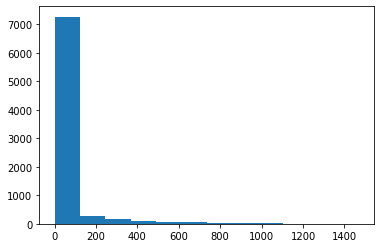

In [ ]:
plt.hist(lens, bins = 12)
plt.show()

# Submission

In [ ]:
import pandas as pd

sub = pd.read_csv('/content/drive/MyDrive/Groom_8th_project2/baseline_post_processing.csv')

In [ ]:
sub = sub.fillna("")
pred = list(sub['Predicted'])
pred

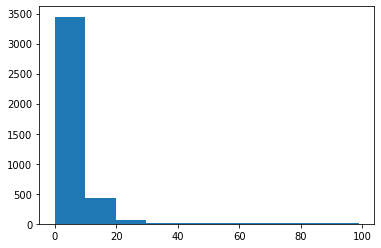

In [ ]:
import matplotlib.pyplot as plt

lens = []
for i in pred:
  lens.append(len(i))


plt.hist(lens)
plt.show()

In [ ]:
for idx,i in enumerate(pred):
  if len(i)>10:
    pred[idx] = ''
print(pred)

['', '', '링크트인', '링크트인', '마드리드', '', '5조원', '', '중합시켜', '노르웨이', '22개', '필리핀', '김교성', '79달러', '존 위클리프', '얀 후스', '지기스문트', '복정역', '법무법인 한울', '', '', '키프로스 섬', '독일', '보석', '', '부레', '프리오노수쿠스', '이산화탄소', '척추', '분류학적 접근', '', '손병석', '', '공직자윤리법', '8월 20일', '현실색', '19조원', '9월22일', '소련 헌법', '인도', '', '갈릴레오', '프라하', '히파르코스', '', '577편', '각막 궤양이', '', '2000만원', '개혁파', '조개류', '아드레날린', '6일', '레이다', '', '도로스', '연방군 수뇌', '샤아 소좌', '쿠니스', '', '', '식품위생법', '이디야', '8개 동의', '5억원', '2004년', '', '2008년', '민간인', '41개', '핵', '데프레닐', '미용', '고려은단', '쿠에농강', '50인치 TV', '', '박씨(朴氏)', '등산 스틱', '70선', '이달 17일', '', '', '3000억원', '', '3만원', '강승훈', '서울시', '19단계', '바리사이파', '이준용', '', '박영효', '강원도관찰사', '이기혁', '불과 한 살', '', "'동물'", '2만3000명', '불어', '박중양', '', '연 4%', '지난 6월5일', '하라 감독', '', '', '무함마드', '봉건제', '위원장', '도쿄', '', '독일 인민당', '117.8%', '여름철', '14건', '2016년', '', '한미약품', '일본', '청산염', '', '납중독의 위험', '', '동전 던지기', '', '10년', '19.8%', '김범수', '', '초음파', '모험 이행', '', '', '13시간', '일본', '184만원', '사포', '63.7%', '2012년', 

In [ ]:
pred_df = pd.DataFrame({'predicted': pred})
pred_df

In [ ]:
new_sub = pd.concat([sub,pred_df], axis=1)
new_sub

,Id,Predicted,predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li 25주년 에디션,
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로,
2,35e61dcb479643448a2cb7d326ae50a6,링크트인,링크트인
3,075e761b370040cb9041eecd39afc27c,링크트인,링크트인
4,e67ed38f3dd944be94d5b4c53731f334,마드리드,마드리드
...,...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,200만엔,200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,중동 건설 현장,
4005,3282034aa41e4fab980851ffd4a868dd,아시아~유럽 노선,
4006,0a73550b36df4baf82ac2f98619d22e7,사흘,사흘


In [ ]:
final = new_sub.drop(new_sub.columns[1], axis=1)
final.to_csv('/content/drive/MyDrive/Groom_8th_project2/finall.csv', sep=',' ,na_rep='')

final

In [ ]:
submission = []

for i in range(4008):
  submission.append([final['Id'][i], final['predicted'][i]])
submission

In [ ]:
import csv
import os
os.makedirs('out', exist_ok=True)
with open('out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])
    writer.writerows(submission)